In [76]:
import pandas as pd
import re
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

import warnings
warnings.filterwarnings('ignore')

## Load and Prepare Data

In [77]:
#Read the dataset and print the top 5 elements of the dataset
df = pd.read_csv('tehranhouses.csv')
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000,116666.67
3475,83,2,True,True,True,Niavaran,6800000000,226666.67
3476,75,2,False,False,False,Parand,365000000,12166.67
3477,105,2,True,True,True,Dorous,5600000000,186666.67


# Explore the data (EDA)

In [78]:
df.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(2), object(2)
memory usage: 146.2+ KB


In [80]:
df["Area2"] = pd.to_numeric(df["Area"] , errors= 'coerce')

In [81]:
df["Area2"].isna().sum()

6

In [82]:
df[df["Area2"].isna()]

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),Area2
570,"3,310,000,000",2,True,True,True,Ostad Moein,3310000000,110333.33,NaN
709,"16,160,000,000",3,True,True,True,Pasdaran,16160000000,538666.67,NaN
807,"1,000",2,True,True,False,Damavand,7000000000,233333.33,NaN
1604,"8,400,000,000",2,True,True,True,Gheitarieh,8700000000,290000.00,NaN
2171,"3,600",2,False,False,False,Shahryar,9720000000,324000.00,NaN
2802,"2,550,000,000",2,True,True,True,Central Janatabad,2550000000,85000.00,NaN


In [83]:
df['Area'] = df['Area'].apply(lambda x: re.sub(',', '', x))
df["Area"] = pd.to_numeric(df["Area"])

In [84]:
df = df.drop('Area2' , axis = 1)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   int64  
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(3), object(1)
memory usage: 146.2+ KB


## preprocessing

<img src="https://www.kdnuggets.com/wp-content/uploads/text-data-task-framework-preprocessing.png" width=75% />

## Missing_Values

In [86]:
df.isnull().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

In [87]:
simple_imp = SimpleImputer(strategy='most_frequent')
imputed = simple_imp.fit_transform(df)

In [88]:
df = pd.DataFrame(imputed , columns = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price', 'Price(USD)'])

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Area        3479 non-null   object
 1   Room        3479 non-null   object
 2   Parking     3479 non-null   object
 3   Warehouse   3479 non-null   object
 4   Elevator    3479 non-null   object
 5   Address     3479 non-null   object
 6   Price       3479 non-null   object
 7   Price(USD)  3479 non-null   object
dtypes: object(8)
memory usage: 217.6+ KB


In [90]:
df["Area"] = pd.to_numeric(df["Area"])
df["Room"] = pd.to_numeric(df["Room"])
df["Parking"] = pd.to_numeric(df["Parking"])
df["Warehouse"] = pd.to_numeric(df["Warehouse"])
df["Elevator"] = pd.to_numeric(df["Elevator"])
df["Price"] = pd.to_numeric(df["Price"])
df["Price(USD)"] = pd.to_numeric(df["Price(USD)"])

## outliers:

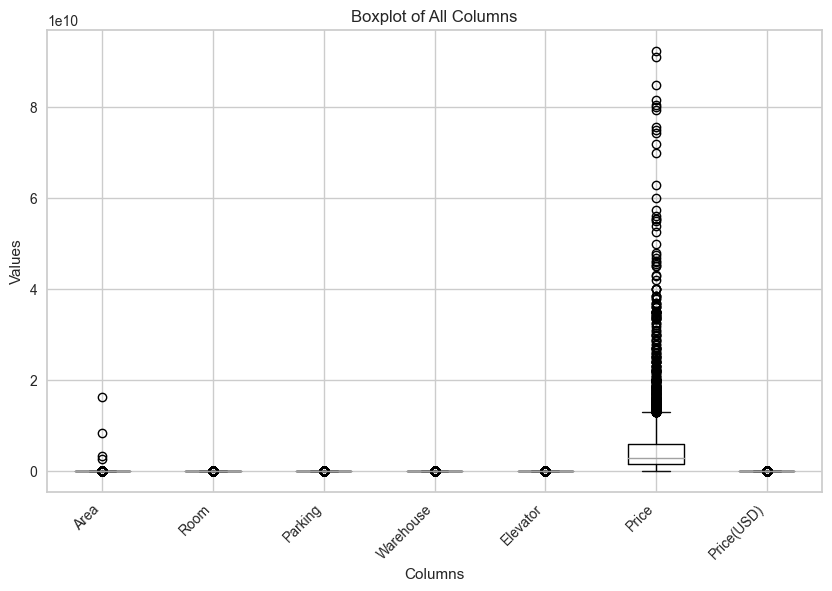

In [91]:
# Step 2: Generate boxplots for each column in the DataFrame
df.drop(['Address'] , axis = 1).boxplot(rot=90, figsize=(10, 6))
plt.title('Boxplot of All Columns')
plt.ylabel('Values')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.show()

In [92]:
Q1 = df.Area.quantile(0.25)
Q3 = df.Area.quantile(0.75)
Q1, Q3

(69.0, 120.0)

In [93]:
IQR = Q3 - Q1
IQR

51.0

In [94]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(-7.5, 196.5)

In [95]:
df = df[~((df.Area<lower_limit)|(df.Area>upper_limit))]

In [96]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000,116666.67
3475,83,2,True,True,True,Niavaran,6800000000,226666.67
3476,75,2,False,False,False,Parand,365000000,12166.67
3477,105,2,True,True,True,Dorous,5600000000,186666.67


In [97]:
Q1 = df.Price.quantile(0.25)
Q3 = df.Price.quantile(0.75)
Q1, Q3

(1300000000.0, 5050000000.0)

In [98]:
IQR = Q3 - Q1
IQR

3750000000.0

In [99]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(-4325000000.0, 10675000000.0)

In [100]:
df = df[~((df.Price<lower_limit)|(df.Price>upper_limit))]

In [101]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000,116666.67
3475,83,2,True,True,True,Niavaran,6800000000,226666.67
3476,75,2,False,False,False,Parand,365000000,12166.67
3477,105,2,True,True,True,Dorous,5600000000,186666.67


## scalling:

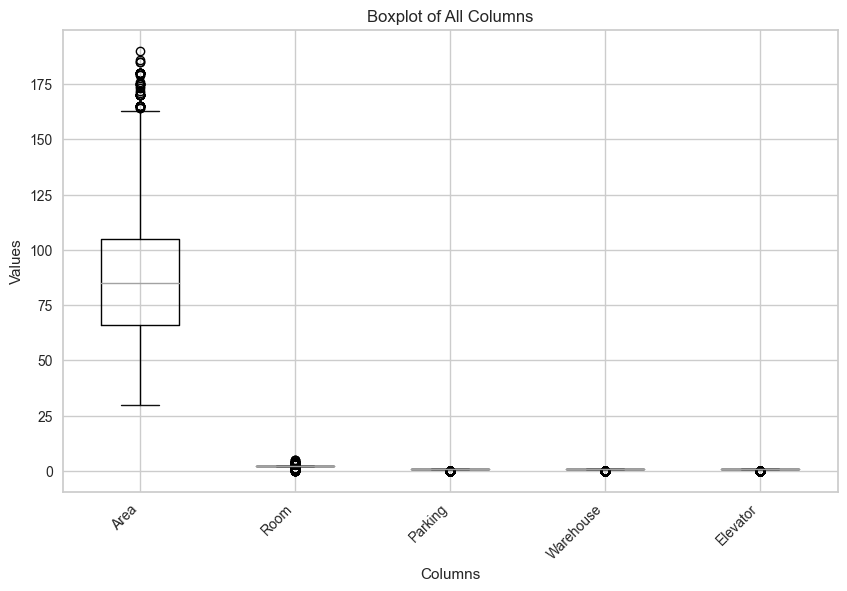

In [102]:
# Step 2: Generate boxplots for each column in the DataFrame
df.drop(['Address' , 'Price' , 'Price(USD)'] , axis = 1).boxplot(rot=90, figsize=(10, 6))
plt.title('Boxplot of All Columns')
plt.ylabel('Values')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.show()

<Axes: >

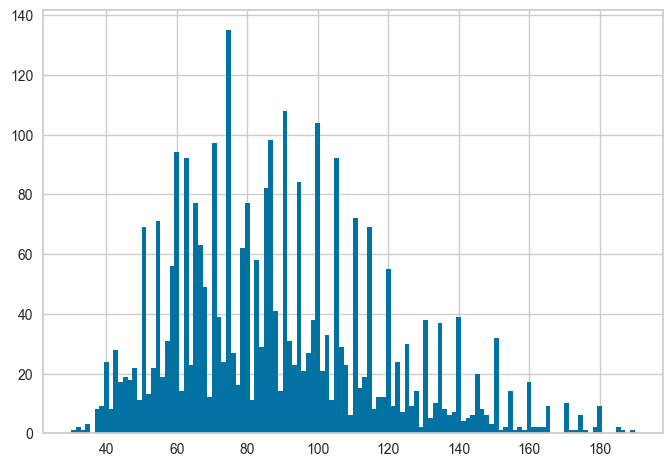

In [103]:
df['Area'].hist(bins = 120)

In [104]:
scaler = StandardScaler()
df['Area'] = scaler.fit_transform(df[['Area']])

In [105]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,-0.872437,1,True,True,True,Shahran,1850000000,61666.67
1,-0.975103,1,True,True,True,Shahran,1850000000,61666.67
2,-0.324887,2,True,True,True,Pardis,550000000,18333.33
3,0.222664,2,True,True,True,Shahrake Qods,902500000,30083.33
4,1.180877,2,True,True,True,Shahrake Gharb,7000000000,233333.33
...,...,...,...,...,...,...,...,...
3474,-0.085333,2,True,True,True,Southern Janatabad,3500000000,116666.67
3475,-0.187999,2,True,True,True,Niavaran,6800000000,226666.67
3476,-0.461774,2,False,False,False,Parand,365000000,12166.67
3477,0.564883,2,True,True,True,Dorous,5600000000,186666.67


<Axes: >

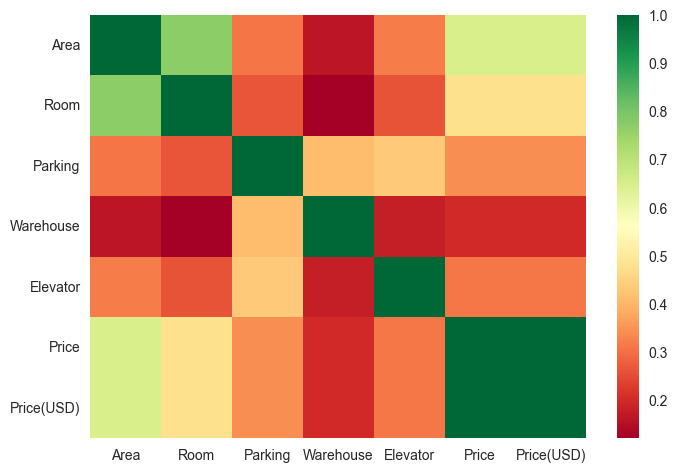

In [106]:
sns.heatmap(df.drop("Address" , axis = 1).corr(),cmap='RdYlGn')

# pycaret

In [107]:
df = df.drop('Price(USD)' , axis = 1)

In [108]:
setup(data = df ,target = 'Price',session_id = 123)

,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(3015, 7)"
4,Transformed data shape,"(3015, 7)"
5,Transformed train set shape,"(2110, 7)"
6,Transformed test set shape,"(905, 7)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [109]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,582723877.9032,884182156920700928.0000,936084392.1907,0.8488,0.3920,0.7035,0.4910
xgboost,Extreme Gradient Boosting,568581615.6095,894673314263414784.0000,942206803.0720,0.8470,0.3899,0.6219,0.0160
gbr,Gradient Boosting Regressor,603078396.7451,907659844225655296.0000,948849804.7357,0.8453,0.4035,0.5942,0.0250
rf,Random Forest Regressor,589870108.4023,938999074221177600.0000,966169212.2084,0.8392,0.4037,0.8078,0.0510
et,Extra Trees Regressor,601794741.8669,982078344868979456.0000,987207693.6754,0.8327,0.4087,0.6544,0.0340
knn,K Neighbors Regressor,649909182.9050,1137901521265422720.0000,1064894899.7552,0.8050,0.4216,0.6157,0.0070
dt,Decision Tree Regressor,685158129.5420,1367933658068429312.0000,1164077244.5643,0.7642,0.4728,0.5272,0.0070
llar,Lasso Least Angle Regression,852754191.1180,1519305240360035584.0000,1230075444.2471,0.7402,0.6808,1.3190,0.0060
lar,Least Angle Regression,852754191.2604,1519305240641900032.0000,1230075444.3567,0.7402,0.6808,1.3190,0.0060
ridge,Ridge Regression,852762816.2010,1519333314961599744.0000,1230086874.6232,0.7402,0.6806,1.3180,0.0050


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [111]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,674772100.7038,1039110385858065024.0000,1019367640.1858,0.8426,0.5073,0.7732
1,557849078.1107,828092315916335488.0000,909995777.9662,0.8199,0.4114,0.3408
2,544463748.2147,678052983787171840.0000,823439726.8697,0.8796,0.3350,0.2635
3,610138998.2811,848577875952321024.0000,921182867.8131,0.8389,0.5760,4.0052
4,501069152.8474,569205824591700160.0000,754457304.6844,0.9096,0.3160,0.2458
5,568416898.6308,895468686783750656.0000,946292072.6624,0.8342,0.3317,0.2599
6,631262887.3349,1014922974958046976.0000,1007433856.3688,0.8520,0.3658,0.3023
7,565213244.8846,940763454049459584.0000,969929612.9356,0.8573,0.3509,0.2642
8,574005124.9609,1156552535248949248.0000,1075431325.2128,0.8111,0.3799,0.2894


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [89]:
tuned_lightgbm = tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,666561567.4703,1033992363655364352.0000,1016854150.6309,0.8434,0.5325,0.7856
1,582652880.5000,818210120878006144.0000,904549678.5020,0.8221,0.4238,0.3421
2,577000132.6188,728380337959099136.0000,853452012.6868,0.8706,0.3488,0.2884
3,620499166.0140,792233014132590848.0000,890074723.9039,0.8496,0.5878,3.4671
4,560525983.7054,694955810724688768.0000,833640096.6392,0.8896,0.4022,0.2633
5,564964225.5881,850640758471845248.0000,922301880.3363,0.8425,0.4079,0.2782
6,650119767.8401,991359225891194880.0000,995670239.5327,0.8554,0.3874,0.3333
7,577857590.9750,980702990566528640.0000,990304493.8636,0.8513,0.3668,0.2645
8,643223137.3832,1386000876018843648.0000,1177285384.2713,0.7736,0.4522,0.3157


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


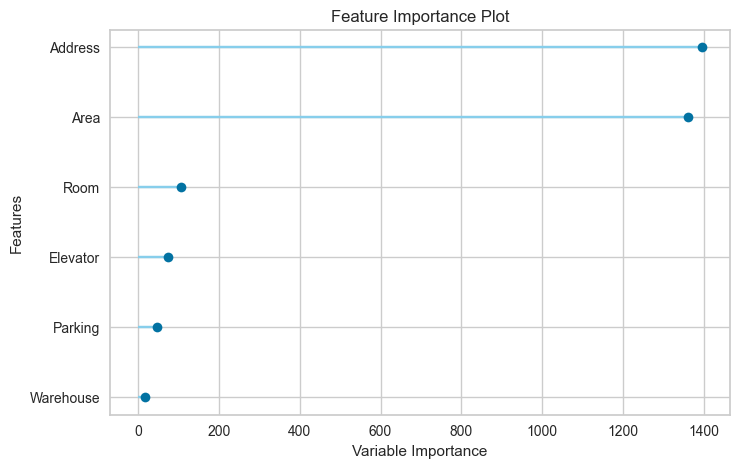

In [90]:
plot_model(estimator = tuned_lightgbm, plot = 'feature')

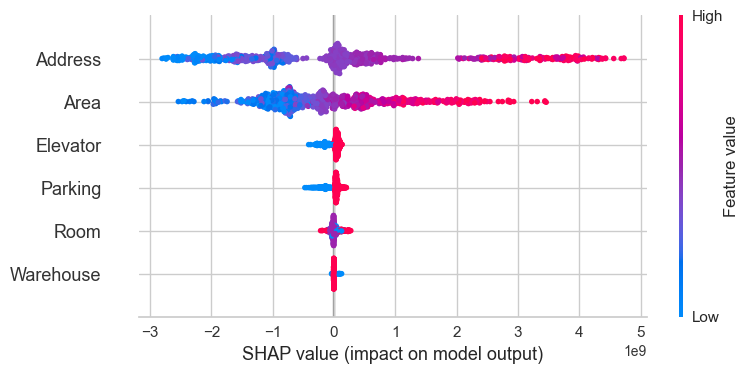

In [91]:
interpret_model(tuned_lightgbm)

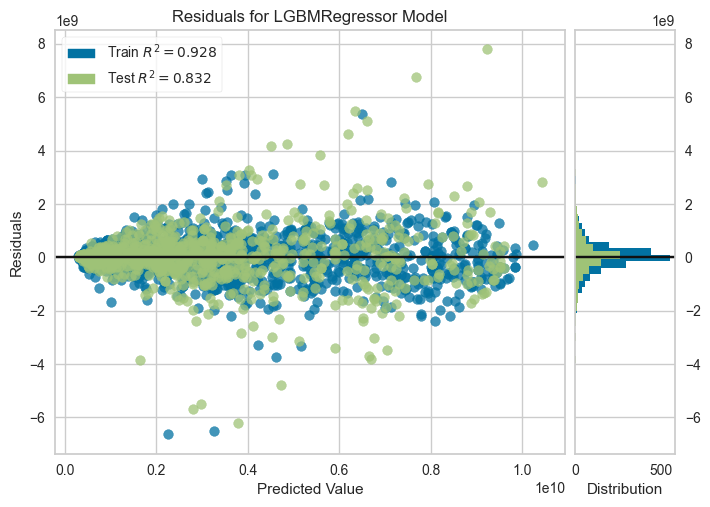

In [92]:
plot_model(tuned_lightgbm)

In [112]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Figure size 800x550 with 0 Axes>

## vizulization

<Figure size 800x500 with 0 Axes>

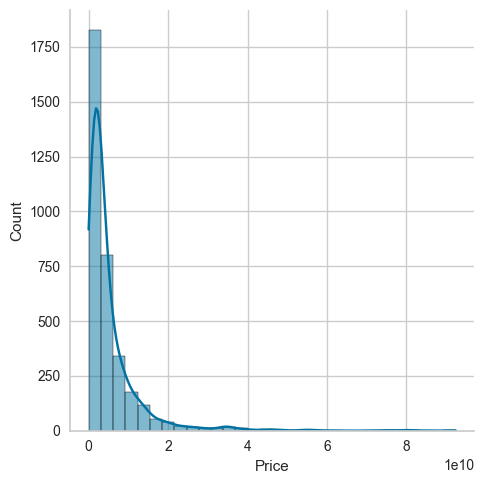

In [23]:
plt.figure(figsize=(8,5))
sns.displot(df['Price'] , bins=30 , kde=True )

In [95]:
df2 = df.drop('Address' , axis = 1)

<Axes: >

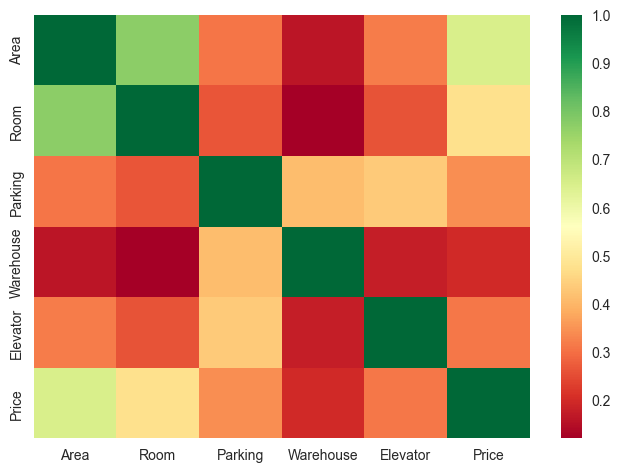

In [96]:
sns.heatmap(df2.corr(),cmap='RdYlGn')

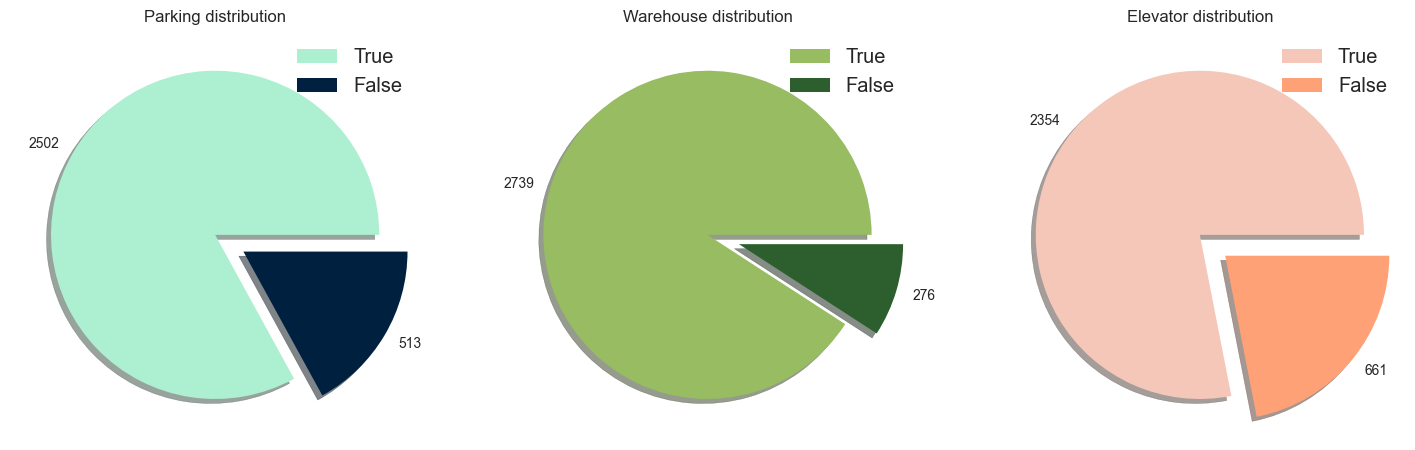

In [97]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Warehouse', 'Elevator']
for i in range(3):
        data = df[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=data.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

In [98]:
df3 = df['Address'].value_counts().copy()
df3 = df3[:8]

Text(0.5, 1.0, 'Number of flats in location')

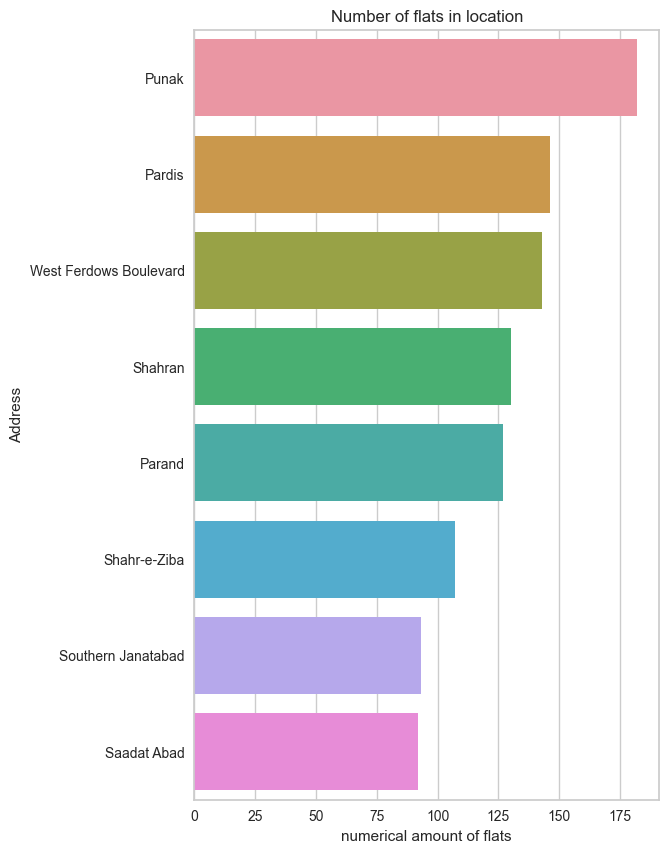

In [99]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x=df3.values, y=df3.index,ax=ax)
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')

In [100]:
df.sort_values('Price',ascending=False)[['Address']].head(20)

,Address
2744,Niavaran
2538,Shahrake Gharb
1826,Saadat Abad
315,Pasdaran
1413,Pasdaran
1422,Saadat Abad
1092,Gheitarieh
2028,Araj
1850,Punak
3333,Shahrake Gharb


# training

In [113]:
#df = df.drop(columns = ['Price(USD)'])
boolean_features = ['Parking','Warehouse','Elevator']
df[boolean_features] = df[boolean_features].astype('int64')

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,-0.872437,1,1,1,1,Shahran,1850000000
1,-0.975103,1,1,1,1,Shahran,1850000000
2,-0.324887,2,1,1,1,Pardis,550000000
3,0.222664,2,1,1,1,Shahrake Qods,902500000
4,1.180877,2,1,1,1,Shahrake Gharb,7000000000


In [114]:
address_dummy = pd.get_dummies(df['Address'])
df_final = df.merge(address_dummy, left_index = True, right_index = True)
df_final.drop(columns = 'Address', inplace = True)
df_final.head(3)

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Abuzar,Afsarieh,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,-0.872437,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.975103,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.324887,2,1,1,1,550000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [115]:
X = df_final.drop(columns = 'Price')
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (2412, 192)
shape of y train: (2412,)
shape of x test: (603, 192)
shape of y train: (603,)


In [116]:
# LightGBM
lgbm = lgb.LGBMRegressor()
lgbm_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

# XGBoost
xgboost = xgb.XGBRegressor()
xgboost_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}


In [117]:
# LightGBM Grid Search
lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, 
                                cv=5, scoring='neg_mean_squared_error', verbose=1 )
lgbm_grid_search.fit(X_train, y_train)
print("Best parameters for LightGBM:", lgbm_grid_search.best_params_)
print("Best score for LightGBM:", np.sqrt(-lgbm_grid_search.best_score_))

# XGBoost Grid Search
xgboost_grid_search = GridSearchCV(estimator=xgboost, param_grid=xgboost_param_grid, 
                                   cv=5, scoring='neg_mean_squared_error', verbose=1 )
xgboost_grid_search.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgboost_grid_search.best_params_)
print("Best score for XGBoost:", np.sqrt(-xgboost_grid_search.best_score_))

# Gradient Boosting Regressor Grid Search
gbr_grid_search = GridSearchCV(estimator=gbr, param_grid=gbr_param_grid, 
                               cv=5, scoring='neg_mean_squared_error', verbose=1 )
gbr_grid_search.fit(X_train, y_train)
print("Best parameters for GBR:", gbr_grid_search.best_params_)
print("Best score for GBR:", np.sqrt(-gbr_grid_search.best_score_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 1929, number of used features: 30
[LightGBM] [Info] Start training from score 3126902746.940383
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1929, number of used features: 31
[LightGBM] [Inf

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1930, number of used features: 29
[LightGBM] [Info] Start training from score 3113093039.253886
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1930, number of used features: 31
[LightGBM] [Info] Start training from score 3157527569.641451
[LightGBM] [Wa

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 1930, number of used features: 32
[LightGBM] [Info] Start training from score 3156490161.475647
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 1929, number of used features: 30
[LightGBM] [Info] Start training from score 3126902746.940383
[LightGBM] [Wa

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1929, number of used features: 31
[LightGBM] [Info] Start training from score 3145633205.947123
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1930, number of used features: 29
[LightGBM] [Info] Start training from score 3113093039.253886
[LightGBM] [Wa

In [118]:
# LightGBM Evaluation test:
best_lgbm = lgbm_grid_search.best_estimator_
lgbm_predictions = best_lgbm.predict(X_test)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_predictions))
lgbm_r2 = r2_score(y_test, lgbm_predictions)

# LightGBM Evaluation test:
lgbm_predictions_train = best_lgbm.predict(X_train)
lgbm_rmse_train = np.sqrt(mean_squared_error(y_train, lgbm_predictions_train))
lgbm_r2_train = r2_score(y_train, lgbm_predictions_train)


print("LightGBM Test RMSE:", lgbm_rmse)
print("LightGBM Test R²:", lgbm_r2)
print("---------------------------")
print("LightGBM train RMSE:", lgbm_rmse_train)
print("LightGBM train R²:", lgbm_r2_train)
print("    ")


# XGBoost Evaluation
best_xgboost = xgboost_grid_search.best_estimator_
xgboost_predictions = best_xgboost.predict(X_test)
xgboost_rmse = np.sqrt(mean_squared_error(y_test, xgboost_predictions))
xgboost_r2 = r2_score(y_test, xgboost_predictions)
# XGBoost Evaluation train
xgboost_predictions_train = best_xgboost.predict(X_train)
xgboost_rmse_train = np.sqrt(mean_squared_error(y_train, xgboost_predictions_train))
xgboost_r2_train = r2_score(y_train, xgboost_predictions_train)


print("XGBoost Test RMSE:", xgboost_rmse)
print("XGBoost Test R²:", xgboost_r2)
print("---------------------------")
print("XGBoost train RMSE:", xgboost_rmse_train)
print("XGBoost train R²:", xgboost_r2_train)
print("    ")


# GBR Evaluation
best_gbr = gbr_grid_search.best_estimator_
gbr_predictions = best_gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_predictions))
gbr_r2 = r2_score(y_test, gbr_predictions)
# GBR Evaluation train 
gbr_predictions_train = best_gbr.predict(X_train)
gbr_rmse_train = np.sqrt(mean_squared_error(y_train, gbr_predictions_train))
gbr_r2_train = r2_score(y_train, gbr_predictions_train)

print("GBR Test RMSE:", gbr_rmse)
print("GBR Test R²:", gbr_r2)
print("---------------------------")
print("GBR train RMSE:", gbr_rmse_train)
print("GBR train R²:", gbr_r2_train)



LightGBM Test RMSE: 1345463316.3238935
LightGBM Test R²: 0.7062063339800355
---------------------------
LightGBM train RMSE: 1083340871.898165
LightGBM train R²: 0.8047485285027436
    
XGBoost Test RMSE: 1029264080.7887424
XGBoost Test R²: 0.8280697321002654
---------------------------
XGBoost train RMSE: 688597399.8954295
XGBoost train R²: 0.9211149298883049
    
GBR Test RMSE: 1011775188.7368004
GBR Test R²: 0.8338628499507904
---------------------------
GBR train RMSE: 595770570.2433728
GBR train R²: 0.9409496941611399


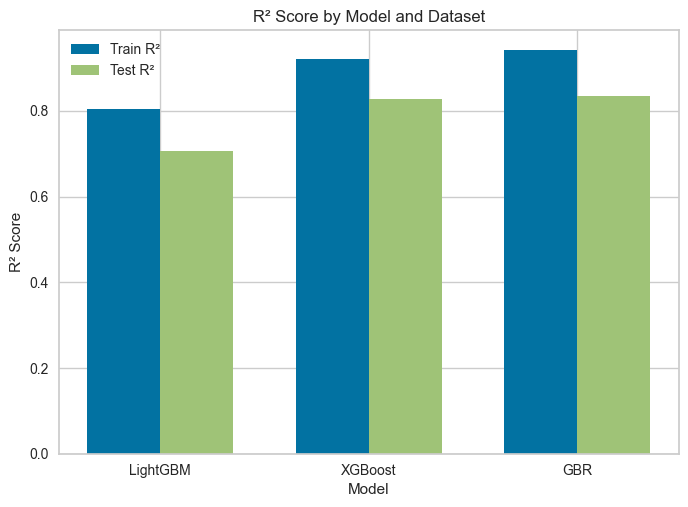

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# R² results for each model
models = ['LightGBM', 'XGBoost', 'GBR']
r2_train = [lgbm_r2_train, xgboost_r2_train, gbr_r2_train]
r2_test = [lgbm_r2, xgboost_r2, gbr_r2]

# Set the positions and width for the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(index, r2_train, bar_width, label='Train R²')
bar2 = ax.bar(index + bar_width, r2_test, bar_width, label='Test R²')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_title('R² Score by Model and Dataset')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Display the bar chart
plt.show()

In [108]:
my_model = 'finalized_model.sav'
joblib.dump(best_gbr, my_model)

['finalized_model.sav']

In [110]:
joblib.dump(scaler, 'std_scaler.bin', compress=True)


['std_scaler.bin']

In [109]:
import wandb
wandb.login()

True

In [ ]:
import wandb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Initialize a wandb run
wandb.init(project='divar house price prediction')

# LightGBM Evaluation test:
best_lgbm = lgbm_grid_search.best_estimator_
lgbm_predictions = best_lgbm.predict(X_test)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_predictions))
lgbm_r2 = r2_score(y_test, lgbm_predictions)
# LightGBM Evaluation train:
lgbm_predictions_train = best_lgbm.predict(X_train)
lgbm_rmse_train = np.sqrt(mean_squared_error(y_train, lgbm_predictions_train))
lgbm_r2_train = r2_score(y_train, lgbm_predictions_train)

print("LightGBM Test RMSE:", lgbm_rmse)
print("LightGBM Test R²:", lgbm_r2)
print("---------------------------")
print("LightGBM train RMSE:", lgbm_rmse_train)
print("LightGBM train R²:", lgbm_r2_train)
print("    ")

# Log LightGBM results
wandb.log({
    'LightGBM Test RMSE': lgbm_rmse,
    'LightGBM Test R²': lgbm_r2,
    'LightGBM Train RMSE': lgbm_rmse_train,
    'LightGBM Train R²': lgbm_r2_train
})

# XGBoost Evaluation
best_xgboost = xgboost_grid_search.best_estimator_
xgboost_predictions = best_xgboost.predict(X_test)
xgboost_rmse = np.sqrt(mean_squared_error(y_test, xgboost_predictions))
xgboost_r2 = r2_score(y_test, xgboost_predictions)
# XGBoost Evaluation train
xgboost_predictions_train = best_xgboost.predict(X_train)
xgboost_rmse_train = np.sqrt(mean_squared_error(y_train, xgboost_predictions_train))
xgboost_r2_train = r2_score(y_train, xgboost_predictions_train)

print("XGBoost Test RMSE:", xgboost_rmse)
print("XGBoost Test R²:", xgboost_r2)
print("---------------------------")
print("XGBoost train RMSE:", xgboost_rmse_train)
print("XGBoost train R²:", xgboost_r2_train)
print("    ")

# Log XGBoost results
wandb.log({
    'XGBoost Test RMSE': xgboost_rmse,
    'XGBoost Test R²': xgboost_r2,
    'XGBoost Train RMSE': xgboost_rmse_train,
    'XGBoost Train R²': xgboost_r2_train
})

# GBR Evaluation
best_gbr = gbr_grid_search.best_estimator_
gbr_predictions = best_gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_predictions))
gbr_r2 = r2_score(y_test, gbr_predictions)
# GBR Evaluation train 
gbr_predictions_train = best_gbr.predict(X_train)
gbr_rmse_train = np.sqrt(mean_squared_error(y_train, gbr_predictions_train))
gbr_r2_train = r2_score(y_train, gbr_predictions_train)

print("GBR Test RMSE:", gbr_rmse)
print("GBR Test R²:", gbr_r2)
print("---------------------------")
print("GBR train RMSE:", gbr_rmse_train)
print("GBR train R²:", gbr_r2_train)

# Log GBR results
wandb.log({
    'GBR Test RMSE': gbr_rmse,
    'GBR Test R²': gbr_r2,
    'GBR Train RMSE': gbr_rmse_train,
    'GBR Train R²': gbr_r2_train
})

# Finish the wandb run
wandb.finish()


403 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>403 Forbidden</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Forbidden</h1>
<h2>Your client does not have permission to get URL <code>/graphql</code> from this server.</h2>
<h2></h2>
</body></html>

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


CommError: It appears that you do not have permission to access the requested resource. Please reach out to the project owner to grant you access. If you have the correct permissions, verify that there are no issues with your networking setup.(Error 403: Forbidden)